# Import module

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_datareader as web
import talib
import seaborn as sns
import gym
from gym import spaces
from gym.utils import seeding
import enum
import pyfolio as pf
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

C:\Users\User\anaconda3\envs\MyDjango\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Stock Data

Stock name: CVX
Start: 2013-02-19 00:00:00, End: 2020-12-31 00:00:00
Training data: 1227 
Tsesting data: 756 


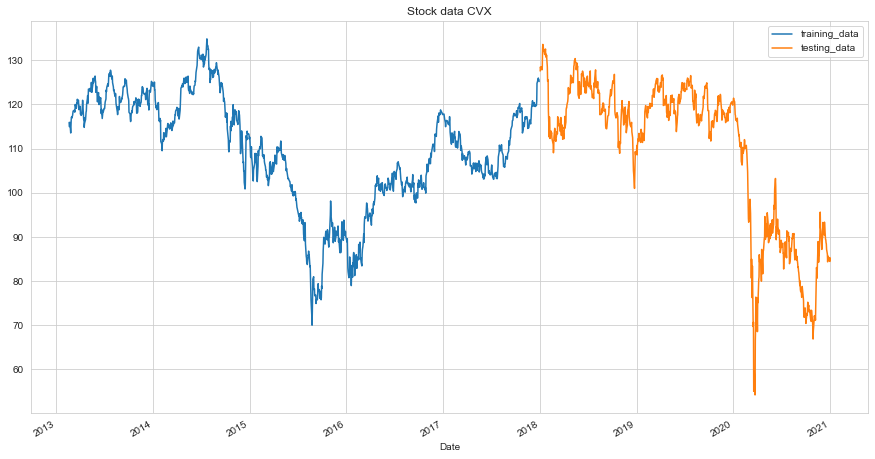

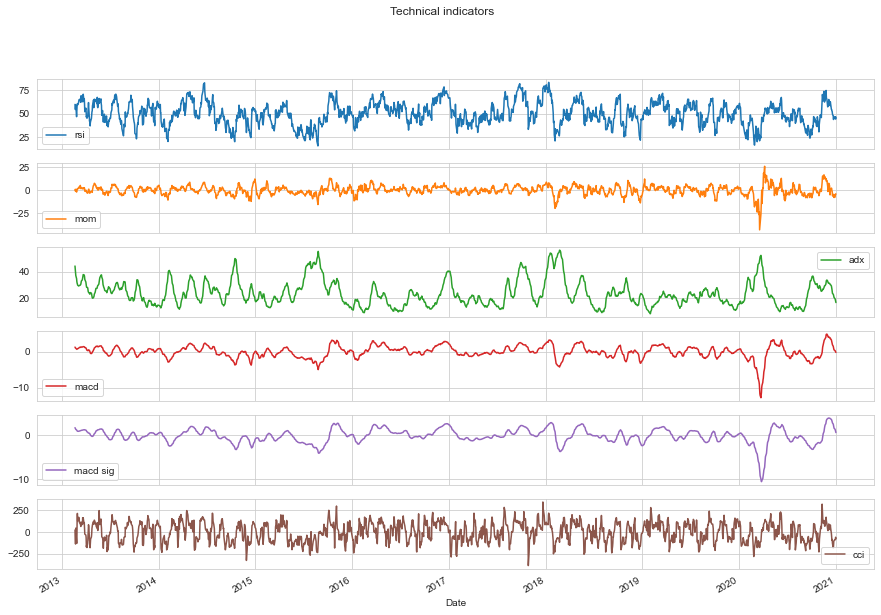

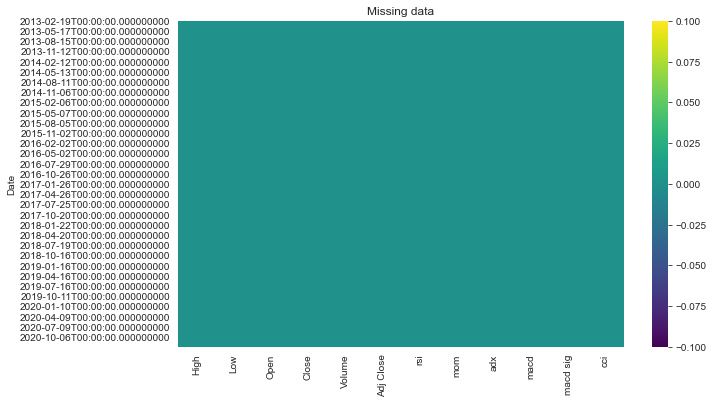

In [ ]:
stock_name = 'cvx'.upper()
industry = 'Energy'
stock_data = web.DataReader(stock_name, 'yahoo', '2013-01-01', '2021-01-01')
stock_data['Volume'] = stock_data['Volume'].apply(lambda vol: np.NaN if vol == 0 else vol)
stock_data['Adj Close'] = stock_data['Close']
stock_data['rsi'] = talib.RSI(stock_data['Adj Close'])
stock_data['mom'] = talib.MOM(stock_data['Adj Close'])
stock_data['adx'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data['macd'], stock_data['macd sig'], _ = talib.MACD(stock_data['Adj Close'])
stock_data['cci'] = talib.CCI(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data.dropna(axis=0, inplace=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]


print(f'Stock name: {stock_name}')
print(f'Start: {stock_data.index[0]}, End: {stock_data.index[-1]}')
print(f'Training data: {len(train_data)} ')
print(f'Tsesting data: {len(test_data)} ')

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(15,8));
test_data['Adj Close'].plot(label='testing_data');
plt.title('Stock data '+ stock_name)
plt.legend();
plt.show()

stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig', 'cci']].plot(subplots=True, figsize=(15,10), title='Technical indicators');
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Missing data');
plt.show()
stock_data.to_csv(f'../train_test_data/{stock_name}.csv')
stock_data.head()

# Agent

In [3]:
    
    
class DQNAgent:
    '''Agent'''

    def __init__(self,
                 input_sz,
                 action_sz,
                 discount_factor=0.9,
                 epsilon=1,
                 epsilon_min=0.001,
                 epsilon_decay=0.995,
                 batch_size=128,
                 lr=0.001,
                 ticker = '',
                 capacity=10000,
                 layers=[100, 100, 100]):
        
        
        # network for predict q values (input = state vector, output = q values dim action size)
        self.network = self.build_model_nn(input_sz, action_sz, layers=layers)
        self.target_network = self.build_model_nn(input_sz, action_sz, layers=layers)
        self.update_target_network()
        
        self.discount_factor = discount_factor  # discount factor (gamma)
        self.reward_window = []
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr) #Adam optimizer learning rate default = 0.001
        self.last_state = torch.Tensor(input_sz).unsqueeze(0)  # shape [1, 5]
        self.last_action = 0
        self.last_reward = 0

        # epsilon greedy selection
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.save_epsilon = []

        self.batch_size = batch_size #batch size
        self.action_sz = action_sz
        self.criterion = nn.MSELoss() #Mean squared error loss
        self.losses = []
        self.stock_name = ticker
        
        #experience replay
        self.capacity = capacity
        self.memory = []
        
        
    def seed(self, seeding=101):
        return torch.manual_seed(seeding)
        
        
    def build_model_nn(self, input_sz, action_sz, layers):
        
        class NeuralNetwork(nn.Module):
            '''
            Network for predict action trading
            '''

            def __init__(self, input_sz, action_sz, layers=[100, 100, 100]):
                super().__init__()
                self.input_sz = input_sz
                self.action_sz = action_sz
                self.fc1 = nn.Linear(input_sz, layers[0])
                self.fc2 = nn.Linear(layers[0], layers[1])
                self.fc3 = nn.Linear(layers[1], layers[2])
                self.out = nn.Linear(layers[2], action_sz)

            def forward(self, state):
                x = F.relu(self.fc1(state))
                x = F.relu(self.fc2(x))
                x = F.relu(self.fc3(x))
                q_values = self.out(x)
                return q_values
        
        self.seed()

        model = NeuralNetwork(input_sz, action_sz, layers=layers)
        
        return model
        
        
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.network.state_dict())
        self.target_network.eval()


    def get_action(self, state):
        '''
        Epsilon-greedy selection
        '''
        
        if np.random.rand() <= self.epsilon:
            # if random samples from a uniform distribution over [0, 1) less than epsilon
            return np.random.choice(self.action_sz) # return random choice of action space
        
        # else return action maximum q values from network
        q_values = self.network(state.clone().detach())
        q_values_prob = F.softmax(q_values * 10, dim=0)
        action = q_values_prob.multinomial(num_samples=1)
        return action.data[0, 0]
    

    def train(self, batch_state, batch_next_state, batch_action, batch_reward):
        outputs = self.network(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        
        next_outputs = self.target_network(batch_next_state).detach().max(1)[0]
        target =  batch_reward + self.discount_factor * next_outputs # reward + gamma*Q(s',a')
        
        loss = F.smooth_l1_loss(outputs, target) # (1/n) * sum(zi)
        self.losses.append(loss.item())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

    def update(self, reward, new_state):
        new_state = torch.tensor(new_state[0]).float().unsqueeze(0) #state vector
        
        # push (last state, new state, last action, last reward into memory)
        self.push((self.last_state,
                  new_state,
                  torch.LongTensor([int(self.last_action)]),
                  torch.Tensor([self.last_reward])))
        # get action
        action = self.get_action(new_state)

        if len(self.memory) > self.batch_size:
            # sample batch event from memory (experience replay)
            batch_state, batch_next_state, batch_action, batch_reward = self.sample(self.batch_size)
            # learn
            self.train(batch_state, batch_next_state, batch_action, batch_reward)

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.save_epsilon.append(self.epsilon)
        
        self.update_target_network()

        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        # add reward to window reward
        if len(self.reward_window) > self.batch_size:
            del self.reward_window[0]
        return action
    
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
            

    def sample(self, batch_size):
        '''
        Sample event from memory (len = batch size)
        '''
        
        # [batch_state, batch_next_state, batch_action, batch_reward]
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)
    

    def score(self):
        return sum(self.reward_window) / (len(self.reward_window) + 1.)

    def save(self):
        torch.save({'state_dict': self.network.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    }, 'state_dict/' + self.stock_name + '.pth')
        print('=> Saved!!!...')

    def load(self):
        if os.path.isfile('state_dict/' + self.stock_name + '.pth'):
            print("loading state dict form " + self.stock_name)
            checkpoint = torch.load('state_dict/' + self.stock_name + '.pth')
            self.network.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.network.eval()
            print('Completed!')
        else:
            print("no parameters found...")    


# Environment

In [4]:
# environment

class Actions(enum.Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(enum.Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long
    


class SingleStockEnv(gym.Env):
    '''
    Single Stock for trading

    '''
    
    metadata = {'render.modes': ['human']}

    def __init__(self, data, capital, trade_fee_bid_percent = 0.01, trade_fee_ask_percent = 0.005):
        
        self.trade_fee_bid_percent = trade_fee_bid_percent/100  # percent
        self.trade_fee_ask_percent = trade_fee_ask_percent/100  # percent
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 9  # [stock price, stock_owned, cash_in_hand, rsi, mom, adx, macd, macd_sig, cci]
        self.save_position = []
        self.save_port_val = []
        self.save_cash = []
        self.total_reward = None
        self.stock_value = []
        self.sell_buy = None
        self.save_stock_price = []
        
        # space
        self.action_space = spaces.Discrete(len(Actions)) # 0, 1, 2
        
        # episode
        self.start_tick = 0
        self.end_tick = self.n_step - 1
        self.current_tick = None
        self.done = None
        self._position = None
        self._position_history = None
        self.save_reward = []
        self.rsi = None
        self.mom = None
        self.adx = None
        self.macd = None
        self.masc_sig = None
        self.cci = None
        
        self.reset()
        

        
        
    def reset(self):
        self.done = False
        self.current_tick = self.start_tick = 0
        self.stock_owned = 0.
        self.stock_price = self.stock_price_history['Adj Close'][self.current_tick]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital]
        self.save_cash = [self.capital]
        self.total_reward = [0]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self._position = Positions.Short
        self._position_history = [self._position]
        self.save_stock_price = [self.stock_price]
        self.rsi = self.stock_price_history['rsi'][self.current_tick]
        self.mom = self.stock_price_history['mom'][self.current_tick]
        self.adx = self.stock_price_history['adx'][self.current_tick]
        self.macd = self.stock_price_history['macd'][self.current_tick]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_tick]
        self.cci = self.stock_price_history['cci'][self.current_tick]
        return self.state_vector()
        

    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi
        vector[4] = self.mom
        vector[5] = self.adx
        vector[6] = self.macd
        vector[7] = self.masc_sig
        vector[8] = self.cci
        return vector


    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand
    

    def trade(self, action):
            
        if (action == Actions.Sell.value and self._position == Positions.Long):
            # sell
            self.cash_in_hand += ((self.stock_owned * self.stock_price) * (1 - self.trade_fee_bid_percent))
            self.stock_owned -= self.stock_owned
            self.sell_buy.append('sell')

        elif (action == Actions.Buy.value and self._position == Positions.Short):            
            # buy
            self.stock_owned += ((self.cash_in_hand * (1 - self.trade_fee_ask_percent)) / self.stock_price)
            self.cash_in_hand -= ((self.cash_in_hand / self.stock_price) * self.stock_price)
            self.sell_buy.append('buy')

            
    def step(self, action):

        prev_port_val = self.port_val()
        self.current_tick += 1
        
        if self.current_tick == self.end_tick:
            self.done = True
            

        
        self.stock_price = self.stock_price_history['Adj Close'][self.current_tick]
        self.rsi = self.stock_price_history['rsi'][self.current_tick]
        self.mom = self.stock_price_history['mom'][self.current_tick]
        self.adx = self.stock_price_history['adx'][self.current_tick]
        self.macd = self.stock_price_history['macd'][self.current_tick]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_tick]
        self.cci = self.stock_price_history['cci'][self.current_tick]
        
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True
            
        if trade:
            self.trade(action)
            self._position = self._position.opposite()
            
        else:
            self.sell_buy.append('hold')
            
        self._position_history.append(self._position)
            
        current_port_val = self.port_val()
        step_reward = current_port_val - prev_port_val
        self.total_reward.append(step_reward)
        self.save_reward.append(step_reward)
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)
        
        
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                'current_val': self.total_reward,
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy,
                }
        return self.state_vector(), step_reward, self.done, info
    
    
    def get_scaler(self):
        states = []
        self.reset()
        for i in range(self.n_step):
            action = self.action_space.sample()
            state, reward, done, info = self.step(action)
            states.append(state)
            if done:
                break
        scaler = StandardScaler()
        scaler.fit(states)
        return scaler

        

# Config

In [5]:
num_episodes = 500
capital = 1000
train_env = SingleStockEnv(data=train_data,
                           capital=capital,
                           trade_fee_bid_percent = 0.01,
                           trade_fee_ask_percent = 0.005)
state_size = train_env.state_dim
nb_action = train_env.action_space.n
agent = DQNAgent(input_sz=state_size,
                 action_sz=nb_action,
                 discount_factor=0.9,
                 ticker=stock_name,
                 batch_size=128,
                 lr=0.001,
                 capacity=10000,
                 layers=[100, 100, 100])
scaler = train_env.get_scaler()

# Training

Training Model


  0%|          | 0/500 [00:00<?, ?it/s]

Episode:    1/500
Begin portfolio value:  1000.00
End portfolio value:     645.73
Since: 1227 days
Return -35.43 %
Epsilon: 0.00214
Sell: 205, Buy: 206
Cumulative Reward:  -354.27
Mean Squared Error Loss:   4.0522


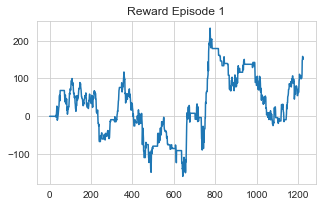


Episode:   25/500
Begin portfolio value:  1000.00
End portfolio value:    1215.81
Since: 1227 days
Return 21.58 %
Epsilon: 0.00100
Sell: 210, Buy: 210
Cumulative Reward:   215.81
Mean Squared Error Loss:   3.7712


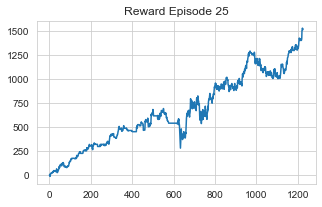


Episode:   50/500
Begin portfolio value:  1000.00
End portfolio value:     824.68
Since: 1227 days
Return -17.53 %
Epsilon: 0.00100
Sell: 206, Buy: 207
Cumulative Reward:  -175.32
Mean Squared Error Loss:   3.8946


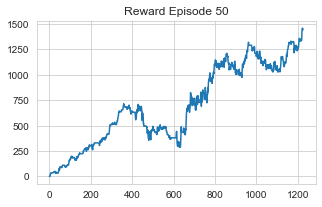


Episode:   75/500
Begin portfolio value:  1000.00
End portfolio value:     897.46
Since: 1227 days
Return -10.25 %
Epsilon: 0.00100
Sell: 208, Buy: 209
Cumulative Reward:  -102.54
Mean Squared Error Loss:   4.4322


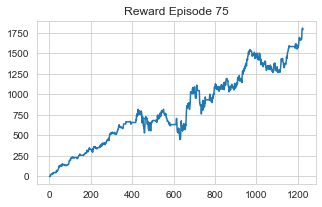


Episode:  100/500
Begin portfolio value:  1000.00
End portfolio value:    1042.85
Since: 1227 days
Return 4.29 %
Epsilon: 0.00100
Sell: 201, Buy: 202
Cumulative Reward:    42.85
Mean Squared Error Loss:   3.1270


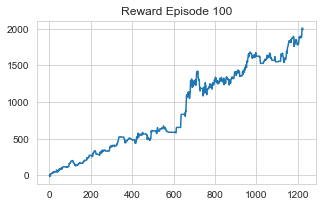


Episode:  125/500
Begin portfolio value:  1000.00
End portfolio value:    1043.16
Since: 1227 days
Return 4.32 %
Epsilon: 0.00100
Sell: 198, Buy: 199
Cumulative Reward:    43.16
Mean Squared Error Loss:   2.5482


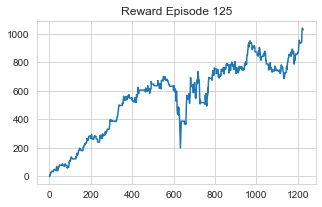


Episode:  150/500
Begin portfolio value:  1000.00
End portfolio value:    1021.92
Since: 1227 days
Return 2.19 %
Epsilon: 0.00100
Sell: 206, Buy: 206
Cumulative Reward:    21.92
Mean Squared Error Loss:   2.9312


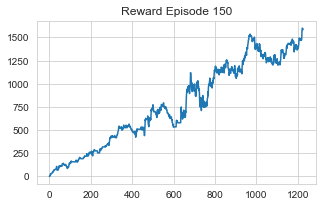


Episode:  175/500
Begin portfolio value:  1000.00
End portfolio value:    1114.01
Since: 1227 days
Return 11.40 %
Epsilon: 0.00100
Sell: 207, Buy: 208
Cumulative Reward:   114.01
Mean Squared Error Loss:   3.0103


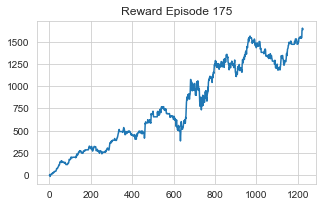


Episode:  200/500
Begin portfolio value:  1000.00
End portfolio value:    1069.16
Since: 1227 days
Return 6.92 %
Epsilon: 0.00100
Sell: 207, Buy: 207
Cumulative Reward:    69.16
Mean Squared Error Loss:   4.1442


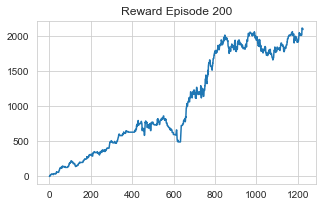


Episode:  225/500
Begin portfolio value:  1000.00
End portfolio value:    1218.30
Since: 1227 days
Return 21.83 %
Epsilon: 0.00100
Sell: 203, Buy: 203
Cumulative Reward:   218.30
Mean Squared Error Loss:   3.0730


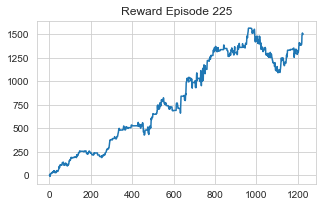


Episode:  250/500
Begin portfolio value:  1000.00
End portfolio value:     804.99
Since: 1227 days
Return -19.50 %
Epsilon: 0.00100
Sell: 189, Buy: 190
Cumulative Reward:  -195.01
Mean Squared Error Loss:   2.6737


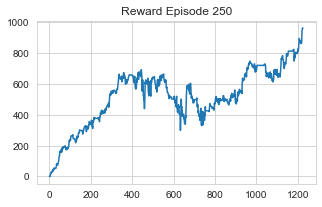


Episode:  275/500
Begin portfolio value:  1000.00
End portfolio value:    1062.55
Since: 1227 days
Return 6.26 %
Epsilon: 0.00100
Sell: 200, Buy: 201
Cumulative Reward:    62.55
Mean Squared Error Loss:   2.9381


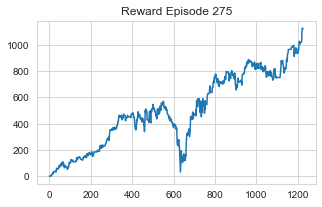


Episode:  300/500
Begin portfolio value:  1000.00
End portfolio value:     889.70
Since: 1227 days
Return -11.03 %
Epsilon: 0.00100
Sell: 210, Buy: 210
Cumulative Reward:  -110.30
Mean Squared Error Loss:   3.5101


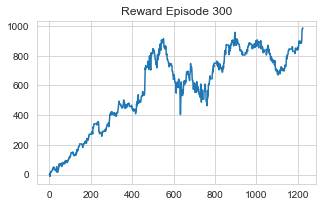


Episode:  325/500
Begin portfolio value:  1000.00
End portfolio value:     901.02
Since: 1227 days
Return -9.90 %
Epsilon: 0.00100
Sell: 220, Buy: 220
Cumulative Reward:   -98.98
Mean Squared Error Loss:   3.5639


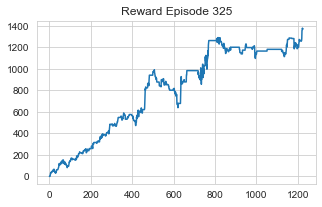


Episode:  350/500
Begin portfolio value:  1000.00
End portfolio value:     756.33
Since: 1227 days
Return -24.37 %
Epsilon: 0.00100
Sell: 206, Buy: 207
Cumulative Reward:  -243.67
Mean Squared Error Loss:   4.0261


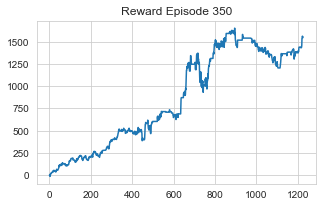


Episode:  375/500
Begin portfolio value:  1000.00
End portfolio value:    1276.43
Since: 1227 days
Return 27.64 %
Epsilon: 0.00100
Sell: 212, Buy: 213
Cumulative Reward:   276.43
Mean Squared Error Loss:   4.7855


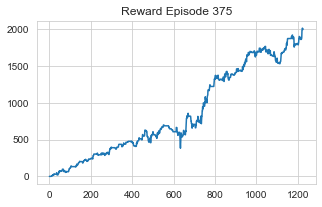


Episode:  400/500
Begin portfolio value:  1000.00
End portfolio value:     978.02
Since: 1227 days
Return -2.20 %
Epsilon: 0.00100
Sell: 209, Buy: 210
Cumulative Reward:   -21.98
Mean Squared Error Loss:   2.9111


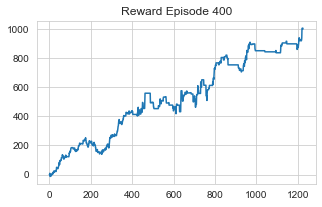


Episode:  425/500
Begin portfolio value:  1000.00
End portfolio value:     883.06
Since: 1227 days
Return -11.69 %
Epsilon: 0.00100
Sell: 204, Buy: 204
Cumulative Reward:  -116.94
Mean Squared Error Loss:   2.8147


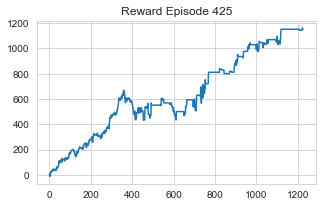


Episode:  450/500
Begin portfolio value:  1000.00
End portfolio value:    1019.85
Since: 1227 days
Return 1.99 %
Epsilon: 0.00100
Sell: 194, Buy: 195
Cumulative Reward:    19.85
Mean Squared Error Loss:   2.6209


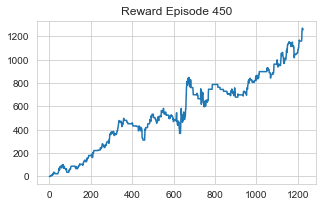


Episode:  475/500
Begin portfolio value:  1000.00
End portfolio value:    1000.23
Since: 1227 days
Return 0.02 %
Epsilon: 0.00100
Sell: 207, Buy: 208
Cumulative Reward:     0.23
Mean Squared Error Loss:   3.2636


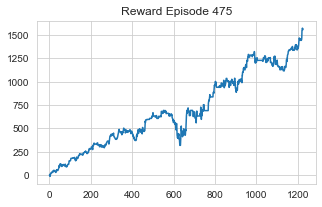


Episode:  500/500
Begin portfolio value:  1000.00
End portfolio value:     939.38
Since: 1227 days
Return -6.06 %
Epsilon: 0.00100
Sell: 208, Buy: 208
Cumulative Reward:   -60.62
Mean Squared Error Loss:   3.3824


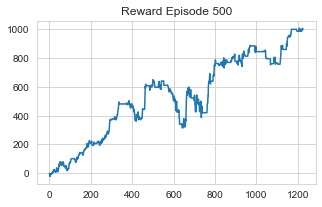


=> Saved!!!...
average reward: 1110.20, min: 469.88, max: 3091.77


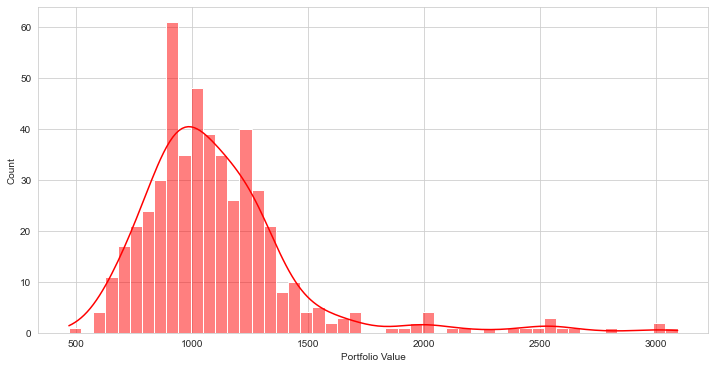

In [6]:
print('Training Model')
portfolio_value = []
total_reward = []
for e in tqdm(range(num_episodes)):
    step_reward = 0
    last_state = train_env.reset()
    last_reward = 0
    done = False
    scores = []
    while not done:
        last_state = scaler.transform([last_state])
        action = agent.update(last_reward, last_state)
        scores.append(agent.score())
        last_state, last_reward, done, info = train_env.step(action) 
        step_reward += last_reward
    
        total_reward.append(step_reward)
    
    if (e+1) % (num_episodes/20) == 0 or (e+1 == 1):     
        print(f"Episode: {e + 1:4}/{num_episodes}")
        print(f"Begin portfolio value: {capital:8.2f}")
        print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
        print(f'Since: {len(train_data)} days')
        print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
        print(f"Epsilon: {agent.save_epsilon[-1]:2.5f}")
        print(f"Sell: {train_env.sell_buy.count('sell')}, Buy: {train_env.sell_buy.count('buy')}")
        print(f'Cumulative Reward: {total_reward[-1]:8.2f}')
        print(f"Mean Squared Error Loss: {agent.losses[-1]:8.4f}")
        
        
        
        env = SingleStockEnv(train_data, capital)
        last_state = env.reset()
        history_reward = []
        _done = False
        while not _done:
            last_state = scaler.transform([last_state])
            last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
            with torch.no_grad():
                action = agent.network(last_state).argmax().item()
            last_state, last_reward, _done, info = env.step(action)
            history_reward.append(last_reward)
        
        pd.Series(history_reward).cumsum().plot(figsize=(5,3))
        plt.title('Reward Episode '+ str(e+1))
        plt.show()
        

        print('=======================================================================')
        print()
    
    portfolio_value.append(info['portfolio_value'][-1]) 

# total_reward = train_env.save_reward

with open(f'scaler/{stock_name}.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
agent.save()
losses = agent.losses

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
plt.figure(figsize=(12,6))
sns.histplot(portfolio_value, bins=50, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

# Loss

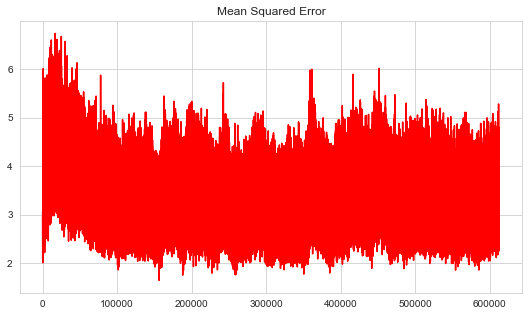

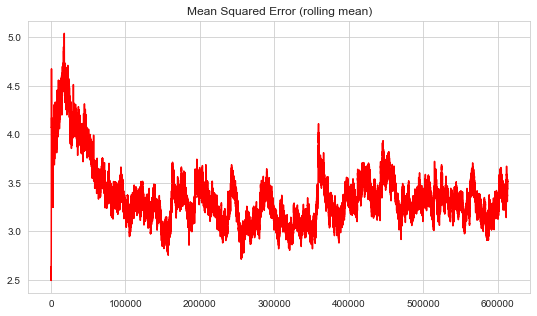

In [7]:
pd.Series(losses).plot(figsize=(9,5), c='r');
plt.title('Mean Squared Error');
plt.show()
pd.Series(losses).rolling(100).mean().plot(figsize=(9,5), c='r');
plt.title('Mean Squared Error (rolling mean)');

# Score

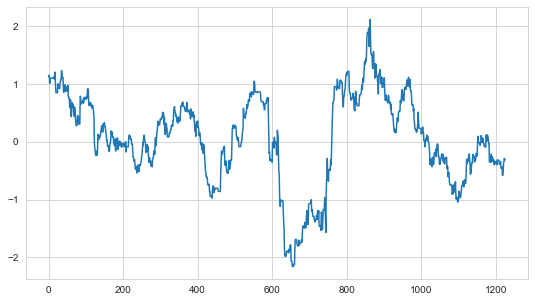

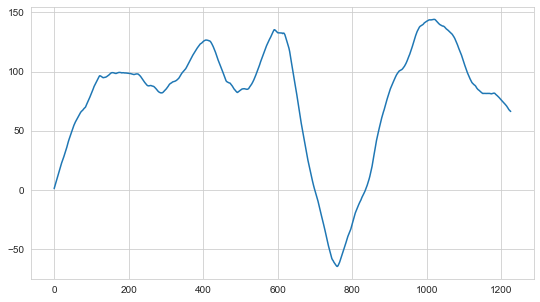

In [8]:
pd.Series(scores).plot(figsize=(9,5));
plt.show()
pd.Series(scores).cumsum().plot(figsize=(9,5));

# Reward

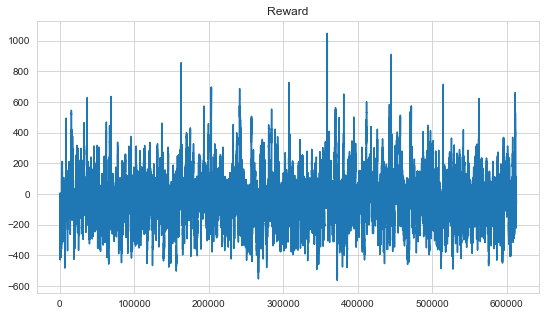

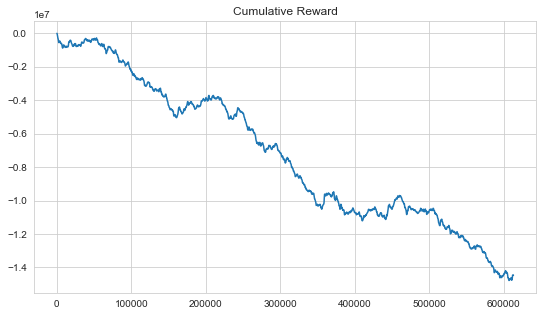

In [9]:
plt.figure(figsize=(9,5));
plt.plot(total_reward);
plt.title('Reward');
plt.show()
pd.Series(total_reward).cumsum().plot(figsize=(9,5));
plt.title('Cumulative Reward');

# Epsilon

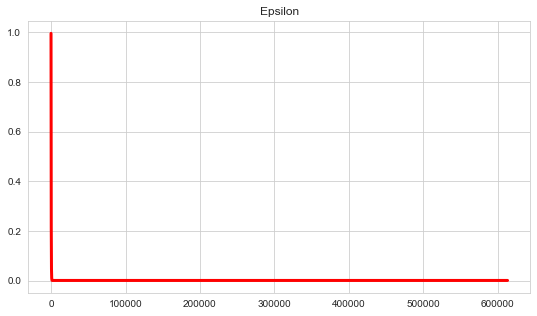

In [10]:
plt.figure(figsize=(9,5))
plt.plot(agent.save_epsilon, lw=3, c='r');plt.title('Epsilon');

# Validation

loading state dict form CVX
Completed!
Testing Model



Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 756 days
Begin portfolio value:  1000.00
End portfolio value:    1998.91
Return 99.89 %
Sell: 155 times, Buy: 156 times


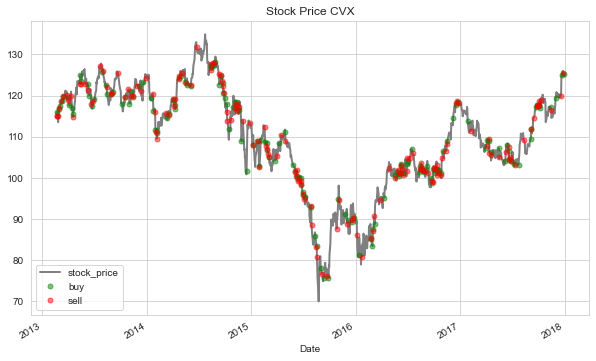

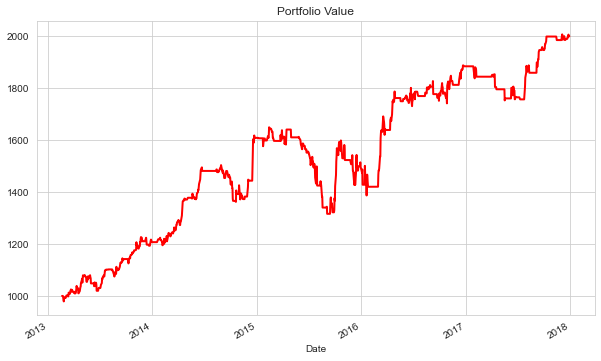

In [5]:
#validation 


capital = 1000
val_env = SingleStockEnv(train_data, capital)
state_size = val_env.state_dim
nb_action = val_env.action_space.n
agent = DQNAgent(state_size, nb_action, 0.9, ticker=stock_name, layers=[100,100,100])
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


last_state = val_env.reset()
last_reward = 0
done = False
agent.load()

while not done:
    last_state = scaler.transform([last_state])
    last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.network(last_state).argmax().item()
    last_state, last_reward, done, info = val_env.step(action)


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {val_env.sell_buy.count('sell')} times, Buy: {val_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = train_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw='2', alpha=1);
result['marker_buy'].plot(style='o', ms=5, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=5, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()


# Testing

loading state dict form CVX
Completed!
Testing Model



Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 756 days
Begin portfolio value:  1000.00
End portfolio value:     894.89
Return -10.51 %
Sell: 98 times, Buy: 99 times


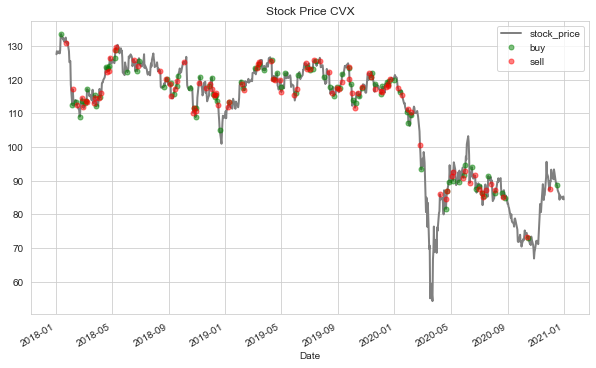

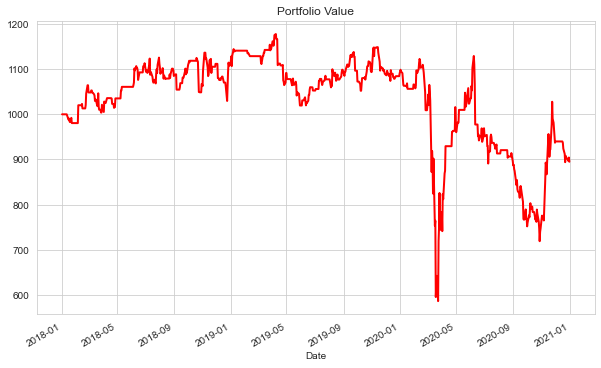

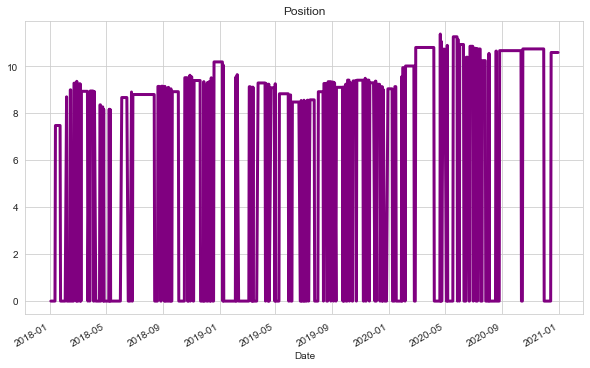

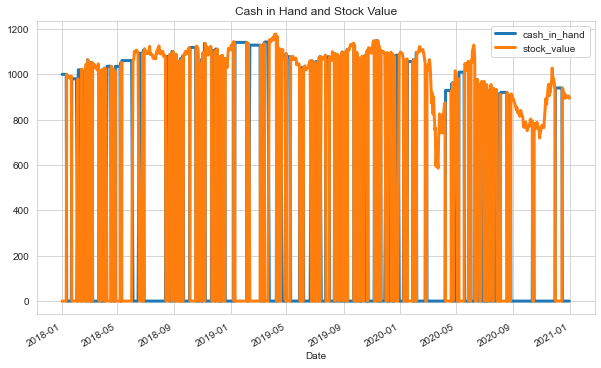

In [6]:
test_env = SingleStockEnv(test_data, capital)
state_size = test_env.state_dim
nb_action = test_env.action_space.n
agent = DQNAgent(state_size, nb_action, 0.9, ticker=stock_name, layers=[100,100,100])
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


last_state = test_env.reset()
last_reward = 0
done = False
agent.load()

while not done:
    last_state = scaler.transform([last_state])
    last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.network(last_state).argmax().item()
    last_state, last_reward, done, info = test_env.step(action)


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {test_env.sell_buy.count('sell')} times, Buy: {test_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw='2', alpha=1);
result['marker_buy'].plot(style='o', ms=5, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=5, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=3);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=3);
plt.title('Cash in Hand and Stock Value');
plt.show()

# Performance Measurement - KPIs

In [7]:
import numpy as np
import datetime as dt

bn = web.DataReader('^GSPC', 'yahoo', '2018-01-01', '2021-01-01')
bn['Benchmark'] = bn['Adj Close']

def CAGR(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    n = len(df)/252
    cagr = (df['cumulative_ret'][-1])**(1/n) - 1
    return cagr

def volatility(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    vol = df['daily_ret'].std() * np.sqrt(252)
    return vol


def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    df['cum_roll_max'] = df['cumulative_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cumulative_ret']
    df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd

def calmer(DF):
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr



print(f'Stock name: {stock_name}')
print(f'Start: {result.index[0]}  End: {result.index[-1]}')
print(f'Compound Annual Growth Rate: {CAGR(result)*100:.2f} %')
print(f'Volatility: {volatility(result):.4f}')
print(f'shape ratio: {sharpe(result, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(result)*-100:.2f} %')
print(f'Calmar ratio: {calmer(result):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Benchmark')
print(f'Compound Annual Growth Rate (benchmark): {CAGR(bn)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(bn):.4f}')
print(f'shape ratio: {sharpe(bn, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(bn)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(bn):.4f}')
print('-----------------------------------------------------------')
print('Comparing with Adj close')
print(f'Compound Annual Growth Rate (Adj close): {CAGR(test_data)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(test_data):.4f}')
print(f'shape ratio: {sharpe(test_data, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(test_data)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(test_data):.4f}')


score = (sharpe(result, 0.011) - sharpe(test_data, 0.011))*10
ret = ((result['portfolio_value'][-1] - result['portfolio_value'][0])/result['portfolio_value'][0]) * 100
with open(f'score/{stock_name}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([stock_name, industry, score, ret], f)

Stock name: CVX
Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Compound Annual Growth Rate: -3.63 %
Volatility: 0.3527
shape ratio: -0.1342
Maximun drawdown: -50.24 %
Calmar ratio: -0.0723
-----------------------------------------------------------
Comparing with Benchmark
Compound Annual Growth Rate (benchmark): 11.69 %
Volatility (benchmark): 0.2334
shape ratio: 0.4537
Maximun drawdown: -33.92 %
Calmar ratio (benchmark): 0.3446
-----------------------------------------------------------
Comparing with Adj close
Compound Annual Growth Rate (Adj close): -12.85 %
Volatility (benchmark): 0.3939
shape ratio: -0.3541
Maximun drawdown: -59.42 %
Calmar ratio (benchmark): -0.2163


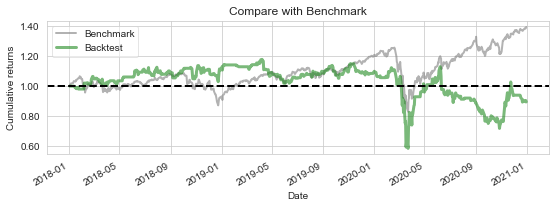

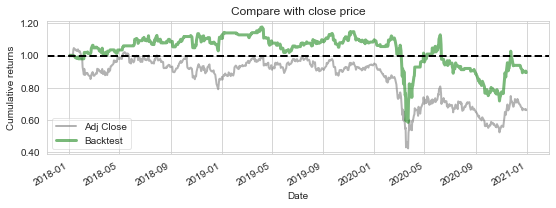

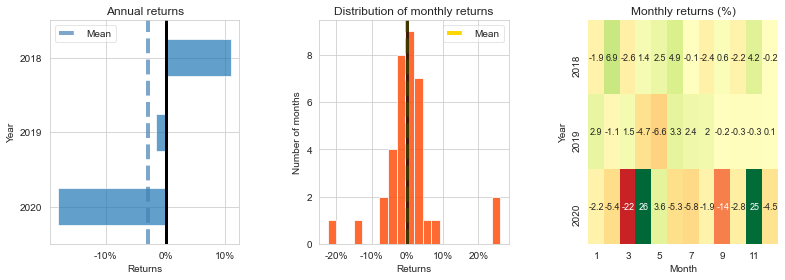

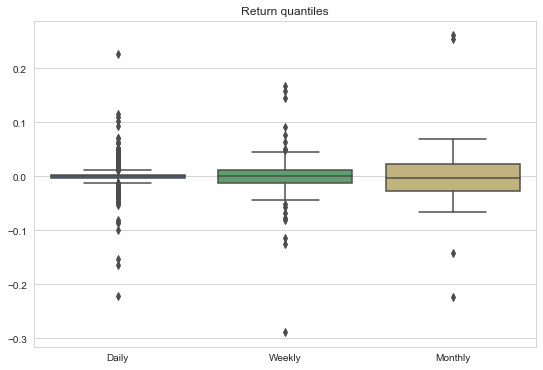

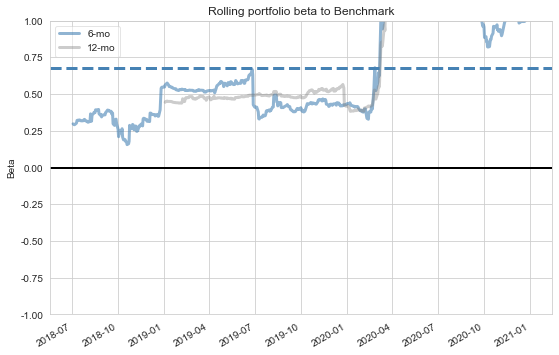

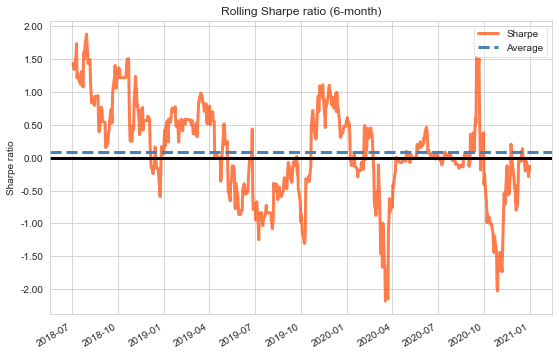

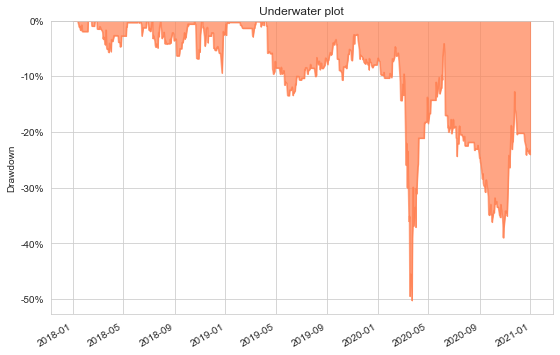

In [8]:
bt_returns = result['portfolio_value'].pct_change()
bm_returns = bn['Benchmark'].pct_change()
price = test_data['Adj Close'].pct_change()

plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, bm_returns);
plt.title('Compare with Benchmark');
plt.show()

plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_rolling_beta(bt_returns, bm_returns);

plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);

In [9]:
result['benchmark'] = bn['Benchmark']
result.to_csv(f'../data/{stock_name}.csv')